In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import scipy.optimize as so
import matplotlib.pyplot as plt

/home/cytech/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


/tmp/ipykernel_5574/3082535268.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cash[t + 1] = cash[t] + cash_jump


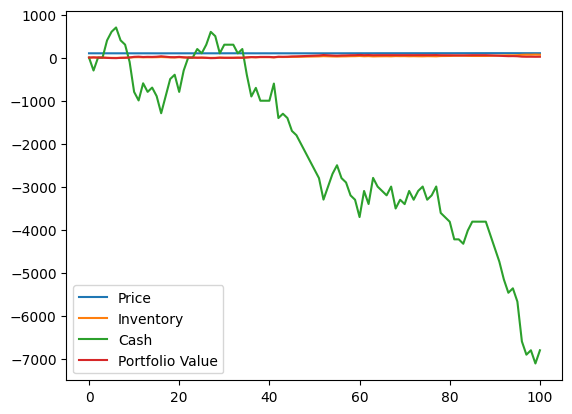

In [ ]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

def price_fluctuation(S_0, N, M, T, sigma):
    dt = T / N
    S = np.zeros((N + 1, M))
    S[0] = S_0
    b_t = ss.norm.rvs(size=(N, M), scale=np.sqrt(dt))
    b_t = np.cumsum(b_t, axis=0)
    b_t = np.vstack((np.zeros(M), b_t))
    S = S_0 + sigma * b_t
    return S

def optimal_spread(sigma, gamma, k, T, q):
    return gamma * sigma**2 * (T - q) / (2 * k)

def bid_ask_quotes(S, sigma, gamma, k, T, q):
    spread = optimal_spread(sigma, gamma, k, T, q)
    mid_price = S[-1]
    bid = mid_price - spread / 2
    ask = mid_price + spread / 2
    return bid, ask

def trading_intensity(S, lambda_ask, lambda_bid):
    N_a = np.random.poisson(lambda_ask)
    N_b = np.random.poisson(lambda_bid)
    cash_jump = N_a * S - N_b * S
    q_t = N_b - N_a
    return N_a, N_b, cash_jump, q_t

def simulate_trading(S_0, N, M, T, sigma, gamma, k, lambda_ask, lambda_bid):
    S = price_fluctuation(S_0, N, M, T, sigma)
    q = np.zeros(N + 1)
    cash = np.zeros(N + 1)
    
    for t in range(N):
        bid, ask = bid_ask_quotes(S[t], sigma, gamma, k, T, q[t])
        N_a, N_b, cash_jump, q_t = trading_intensity(S[t], lambda_ask, lambda_bid)
        q[t + 1] = q[t] + q_t
        cash[t + 1] = cash[t] + cash_jump
    
    portfolio_value = cash + q * S[-1]
    return S, q, cash, portfolio_value

S_0 = 100
N = 100
M = 1
T = 1
sigma = 2
gamma = 0.1
k = 1.5
lambda_ask = 5
lambda_bid = 5

S, q, cash, portfolio_value = simulate_trading(S_0, N, M, T, sigma, gamma, k, lambda_ask, lambda_bid)

plt.plot(S, label='Price')
plt.plot(q, label='Inventory')
plt.plot(cash, label='Cash')
plt.plot(portfolio_value, label='Portfolio Value')
plt.legend()
plt.show()